# Toy Model: Memorizing an Orthogonal Training Set
@henighan 11 Nov 2022

Here I demonstrate that:
- the ReLU output model $\text{ReLU}(X W W^T + b)$ can memorize an infinite number of orthonormal training examples for $m \geq 2$ (if given infinite precision).
- The frobenius norm of $W$ grows roughly linearly with the number of training examples.
- If we untie the weights by replacing $W^T$ with a separate matrix $W_{up}$, the training set need only be orthogonal, not orthonormal.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Suppose we have a finite train dataset with T training examples and n features. We can represent it as a matrix $X \in \mathbb{R}^{n \times F}$. We’ll use $x_i \in \mathbb{R}^n$ to denote individual training examples, which are the rows of $X$.


Let’s further suppose that the $x_i$ are orthogonal 1-hot vectors. If F > T, X will have some zero-columns (ie features that never fire), which can safely drop. Furthermore, we can reorder the rows of $X$ such that $X=$ the identity matrix $I$ without loss of generality.


In [ ]:
T = 6
X = np.eye(T)

It is now our task to find $W \in R^{T \times 2}$ and $b \in R^T$ such that
$$
X = \text{ReLU}(XWW^T + b)
$$

where 2 is our hidden size.

We will begin with an ansatz (ansatz is a fancy word for “a guess”) for $W$

$$
W = \alpha * \begin{bmatrix}
 \cos(0) & \sin(0) \\
 \cos(\phi) &  \sin(\phi)  \\
\cos(2 \phi)  &  \sin(2 \phi)  \\
 \vdots & \vdots  \\
 \vdots & \vdots  \\
\cos((T-2) \phi) & \sin((T-2) \phi) \\
\cos((T-1) \phi) & \sin((T-1) \phi)
\end{bmatrix}
, \
\phi \equiv \frac{2 \pi}{T}
$$

The rows of $XW$, which correspond to the hidden-vectors for each training example, will be points equally spaced on a circle with radius $\alpha$. For $T=3$ they will form a triangle, for $T=5$ they will form a pentagon, and so on.

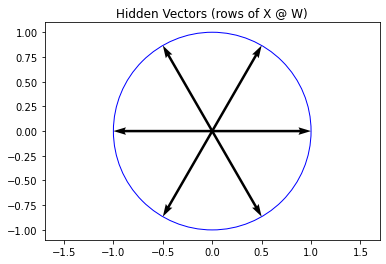

In [ ]:
phi = 2*np.pi/T
# use alpha=1 for now
alpha = 1
W = alpha * np.array([[np.cos(ii * phi), np.sin(ii * phi)] for ii in range(T)])

hidden_vecs = X @ W

plt.quiver(
    np.zeros(T), np.zeros(T),
    hidden_vecs[:,0], hidden_vecs[:,1],
    scale=1, units="xy", scale_units="xy",
)
plt.gca().add_patch(plt.Circle((0, 0), alpha, color='b', fill=False))
lim = 1.0
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])
plt.axis('equal')
plt.title("Hidden Vectors (rows of X @ W)")
plt.show()


$XWW^T$ will then be:

$$
XWW^T = \\ \alpha^2 \begin{bmatrix}
 \cos(0)^2 + \sin(0)^2 & \cos(0)\cos(\phi) + \sin(0)\sin(\phi)  & \cos(0)\cos(2\phi) + \sin(0)\sin(2\phi) & \cdots & \cos(0)\cos(-\phi) + \sin(0)\sin(-\phi) \\
  \cos(\phi)\cos(0) + \sin(\phi)\sin(0) & \cos(\phi)^2 + \sin(\phi)^2 & \cos(\phi)\cos(2\phi) + \sin(\phi)\sin(2\phi) & \cdots & \cos(\phi)\cos(-\phi) + \sin(\phi)\sin(-\phi)\\
\cos(2 \phi)\cos(0) + \sin(2\phi)sin(0)  &  \cos(2 \phi)\cos(\phi) + \sin(2\phi)\sin(\phi) & \cos(2\phi)^2 + \sin(2\phi)^2  & \cdots & \cos(2\phi)\cos(-\phi) + \sin(2\phi)\sin(-\phi) \\
 \vdots & \vdots   & \vdots & \ddots & \vdots \\
\cos(-2 \phi)\cos(0) + \sin(-2\phi)sin(0)  &  \cos(-2 \phi)\cos(\phi) + \sin(-2\phi)\sin(\phi) & \cos(-2\phi)\cos(2\phi) + \sin(-2\phi)\sin(2\phi)  & \cdots & \cos(-2 \phi)\cos(-\phi) + \sin(-2\phi)sin(-\phi)\\
\cos(-\phi)\cos(0) + \sin(-\phi)sin(0)  &  \cos(-\phi)\cos(\phi) + \sin(-\phi)\sin(\phi) & \cos(-\phi)\cos(2\phi) + \sin(-\phi)\sin(2\phi)  & \cdots  & \cos(-\phi)^2 + \sin(-\phi)^2 \\
\end{bmatrix}
$$

Where I've used the identity $(T-i)\phi = -i\phi$ for brevity.

We can simplify the above using the trigonometric identity $\cos(\theta_1 - \theta_2) = \cos(\theta_1)\cos(\theta_2) + \sin(\theta_1)\sin(\theta_2)$


$$
XWW^T = \\ \alpha^2 \begin{bmatrix}
 \cos(0) & \cos(\phi)  & \cos(2\phi) & \cdots & \cos(-\phi) \\
 \cos(-\phi) & \cos(0) & \cos(\phi)  &  \cdots & \cos(-2\phi) \\
 \cos(-2\phi) & \cos(-\phi) & \cos(0) &   \cdots & \cos(-3\phi) \\
 \vdots & \vdots   & \vdots & \ddots & \vdots \\
\cos(2 \phi)  &  \cos(3\phi) & \cos(4\phi)  & \cdots &  \cos(\phi)\\
\cos(\phi)  &  \cos(2\phi) & \cos(3\phi)  & \cdots  & \cos(0) \\
\end{bmatrix}
$$




In [ ]:
np.testing.assert_allclose(
    X @ W @ W.T,
    np.array([[np.cos((column - row) * phi) for row in range(T)] for column in range(T)]),
)

From here we can pick the correct value for $b$ by noting that the largest entries are on the diagonal with value $\alpha^2 \cos(0) = \alpha^2 $ and the next largest entries are $\alpha\cos(\pm \phi)$.

$$
b = - \alpha^2 \cos(\phi)
$$

For which
$$
\text{ReLU}(XWW^T + b) = \alpha^2 (1 - \cos(\phi)) I
$$

where $I$ is the identity matrix. This leaves nonzero entries on the diagonal alone.




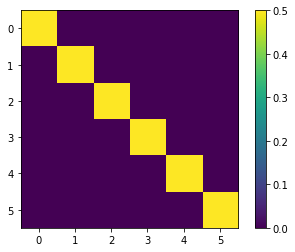

In [ ]:
b = -alpha**2 * np.cos(phi)
relu = lambda x: np.maximum(x, 0)

X_hat = relu(X @ W @ W.T + b)
plt.imshow(X_hat)
plt.colorbar()
plt.show()

From the above, we see that the correct choice for $\alpha$ is
$$
\alpha = (1-\cos(\phi))^{-1/2}
$$

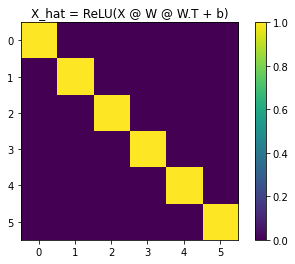

In [ ]:
alpha = (1 - np.cos(phi))**-0.5
W = alpha * np.array([[np.cos(ii * phi), np.sin(ii * phi)] for ii in range(T)])
b = -alpha**2 * np.cos(phi)
X_hat =  relu(X @ W @ W.T + b)
plt.imshow(X_hat)
plt.title("X_hat = ReLU(X @ W @ W.T + b)")
plt.colorbar()
plt.show()
np.testing.assert_allclose(X, X_hat, atol=1e-6)

# Lifting the One-Hot vector assumption

If our our train set is orthonormal and has all positive-entries, it is different from the one-hot $X$ proposed above by a particularly simple linear transformation: a block-diagonal matrix $R$, where each block is a rotation operating in one training example's unique subspace. Below is a concrete example for T=2, n=4.

$$
X = X_0 R =  \begin{bmatrix}
 1 & 0 & 0 & 0 \\
 0 & 0 & 1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
 \cos(\theta_1) & \sin(\theta_1) & 0 & 0 \\
 -\sin(\theta_1) & \cos(\theta_1) & 0 & 0 \\
 0 & 0 & \cos(\theta_2) & -\sin(\theta_2) \\
 0 & 0 & \sin(\theta_2) & \cos(\theta_2) \\
\end{bmatrix}
=
\begin{bmatrix}
 \cos(\theta_1) & \sin(\theta_1) & 0 & 0 \\
 0 & 0 & \cos(\theta_2) & \sin(\theta_2) \\
\end{bmatrix}
$$

Where $0 \leq \theta_i \leq \pi/2$ to keep all entries of $X \geq 0$.

In the above, I've factored $X$ into $X_0$ and $R$, where $X_0$ has one-hot rows, and $R$ is the block-diagonal rotations I described above. We already know the one-hot solution, namely:

$$
W_0 = \alpha * \begin{bmatrix}
 \cos(0) & \sin(0) \\
 0 & 0 \\
 \cos(\phi) &  \sin(\phi)  \\
 0 & 0 \\
\end{bmatrix}
\\
b_0 = -\alpha^2 \cos(\phi) * [1, 0, 1, 0]
$$

I then claim we can find the solution for $X$ as follows:

$$
W = R^T W_0
\\
b = b_0 R
$$

Below, I empirically demonstrate that this works for a handful of randomly chosen $R$s.

In [ ]:
T = 6
F = 2 * T
phi = 2*np.pi/T
X_0 = np.zeros((T, F))
for ii in range(0, T):
  X_0[ii, 2*ii] = 1
W_0 = np.zeros((F, 2))
b_0 = np.zeros(F)
for row in range(0, F, 2):
  W_0[row] = alpha * np.array([np.cos(row // 2 * phi), np.sin(row // 2 * phi)])
  b_0[row] = -alpha**2 * np.cos(phi)
X_0_hat = relu(X_0 @ W_0 @ W_0.T + b_0)
# verify X_0 solution
np.testing.assert_allclose(X_0, X_0_hat, atol=1e-6)

def rot_mat_2d(theta):
  return np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

# verify X solution for randomly-chosen R
n_trials = 10
for _ in range(n_trials):
  random_thetas = np.pi/2 * np.random.rand(T)
  R = np.zeros((F, F))
  for ii, random_theta in enumerate(random_thetas):
    R[2*ii:2*ii+2,2*ii:2*ii+2] = rot_mat_2d(random_theta)
  X = X_0 @ R
  W = R.T @ W_0
  b = b_0 @ R
  X_hat = relu(X @ W @ W.T + b)
  np.testing.assert_allclose(X, X_hat, atol=1e-6)
print("Success!")

Success!


# Lifting the Unit-Norm Assumption

The above solution generally only works if all the traning examples $x_i$ have the same norm.

However the above solution does work if we untie the weights. The only difference is that we need to choose different values of $\alpha$ for for $W$ and $W_{up} \neq W^T$. Untied weights are probably a more faithful proxy for what happens in real neural networks.



# The Orthogonality Assumption

The above solution breaks down when the training examples $x_i$ are not orthogonal. I'd guess we could think of small amounts of $x_i$ overlap as a perturbation on top of the solution presented here, but 🤷.

# Observation: $||W||_2 ∝ T^{3/2}$ for large $T$.

Our solution for $W$ has a frobenius norm given by
$$
||W||_2 = \alpha \sqrt{T} = \sqrt{\frac{T}{1 - \cos(2\pi/T)}}
$$.

For large $T$ this becomes

$$
||W||_2 \approx \sqrt{\frac{T^3}{2 \pi^2}}
$$

which shows that, for large T, $||W||_2$ grows like $T^{3/2}$.

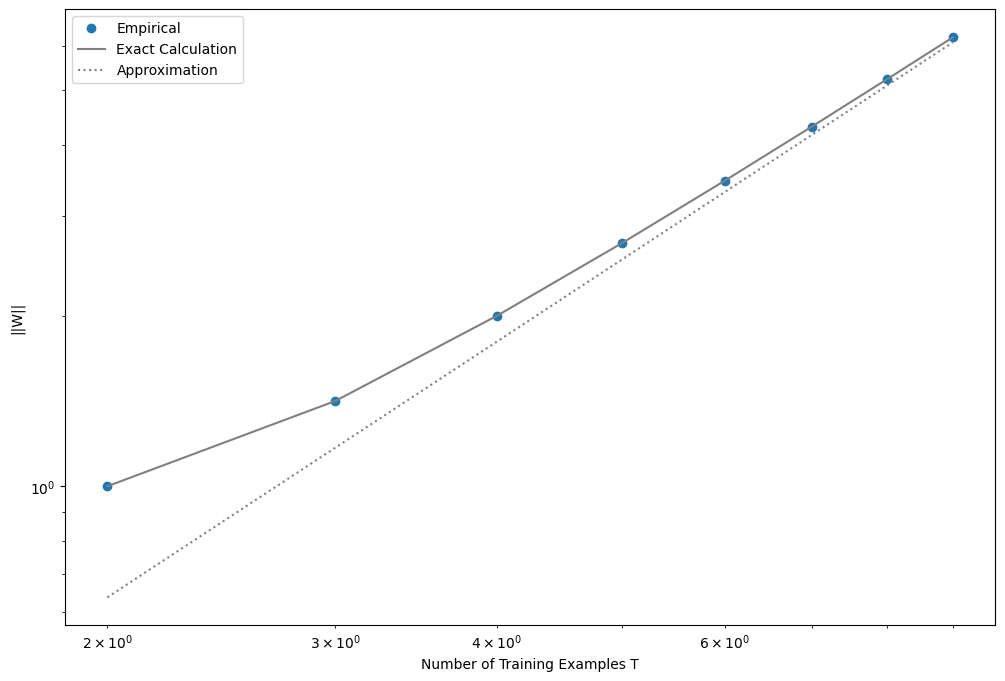

In [ ]:
T_array = np.arange(2, 10)
measured_W_norms = []
for T in T_array:
  phi = 2*np.pi/T
  alpha = (1 - np.cos(phi))**(-1/2)
  W = alpha * np.array([[np.cos(ii * phi), np.sin(ii * phi)] for ii in range(T)])
  measured_W_norms.append(np.linalg.norm(W))
exact_calculated_norms = np.sqrt(T_array/(1-np.cos(2*np.pi/T_array)))
approximated_norms = np.sqrt(T_array**3/2/np.pi**2)
plt.loglog(T_array, measured_W_norms, "o", label="Empirical")
plt.loglog(T_array, exact_calculated_norms, "-", color="grey", label="Exact Calculation")
plt.loglog(T_array, approximated_norms, ":", color="grey", label="Approximation")
plt.xlabel("Number of Training Examples T")
plt.ylabel("||W||")
plt.legend()
plt.show()

Meanwhile, $||b||$ is given by:
$$
||b|| = \sqrt{T} \alpha^2 \cos(\phi) = \frac{\sqrt{T} \cos(\frac{2 \pi}{T})}{1 - \cos(\frac{2 \pi}{T})}
$$

Here the large-T limit is:
$$
||b|| \approx \frac{T^{5/2}}{2 \pi^2}
$$
